# Python notebook for post-processing apical responses.
# Frequency analysis of results data.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [1]:
import csv
import glob
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fftpack import fft, fftfreq
from scipy.linalg import dft
from scipy.interpolate import interp1d
from scipy.io.wavfile import write
from scipy import signal


#### Select a results directory and set analysis frame range.


In [2]:
%matplotlib widget

# global variables
results_sel = ""  # the selected results directory
stim_start = 100  # analysis start frame
stim_done = 250   # analysis end frame
calc_method = 'FB'
results_scale = 'linear'

s = {'description_width':'200px'} # a default widget style

# create results directory widget
result_dirs = sorted([f.split('/')[-2] for f in glob.glob("../results/*/", recursive=False)], key=str.casefold)
results_widget = widgets.Select(options=result_dirs, description='Results dir', 
                            disabled=False, layout=widgets.Layout(width='400px'))
# create numeric input widgets
stim_start_widget = widgets.BoundedIntText(value=stim_start, min=0, max=1000, step=1,
                    description='Stimulation start frame', disabled=False, layout={'width':'270px'}, style=s)
stim_done_widget = widgets.BoundedIntText(value=stim_done, min=0, max=1000, step=1,
                    description='Stimulation done frame', disabled=False, layout={'width':'270px'}, style=s)

# create status widget
status_widget = widgets.HTML(value=' ', description=' ')

# create method widget
method_widget = widgets.Dropdown(options=['FFT', 'FB'], value=calc_method, description='Calculation method',
                disabled=False, layout={'width':'270px'}, style=s)

# create results scale widget
scale_widget = widgets.Dropdown(options=['linear', 'log'], value=results_scale, description='Results scale',
                disabled=False, layout={'width':'300px'}, style=s)

# display and respond to the widgets
def f(w1, w2, w3, w4, w5, w6):
  global results_sel
  global stim_start, stim_done, calc_method, results_scale
  results_sel = results_widget.value
  stim_start = stim_start_widget.value
  stim_done = stim_done_widget.value
  calc_method = method_widget.value
  results_scale = scale_widget.value

  if not results_sel:
    status_widget.value = "No result directory selected."
  else:
    status_widget.value = "Selection OK."
display(widgets.interactive(f, w1=results_widget, w2=status_widget,
                           w3=stim_start_widget, w4=stim_done_widget, w5=method_widget, w6=scale_widget))

interactive(children=(Select(description='Results dir', layout=Layout(width='400px'), options=('20200713-20182…

#### Frequency analysis of results over all regions.

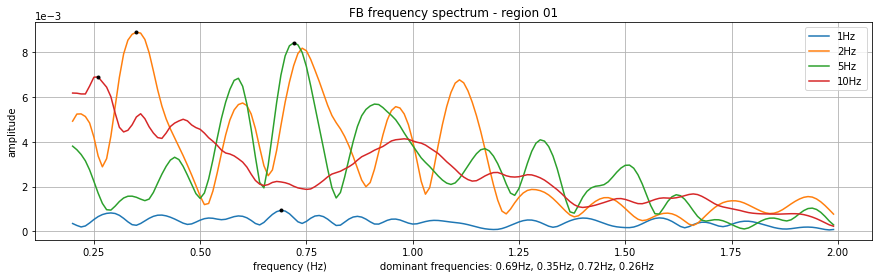

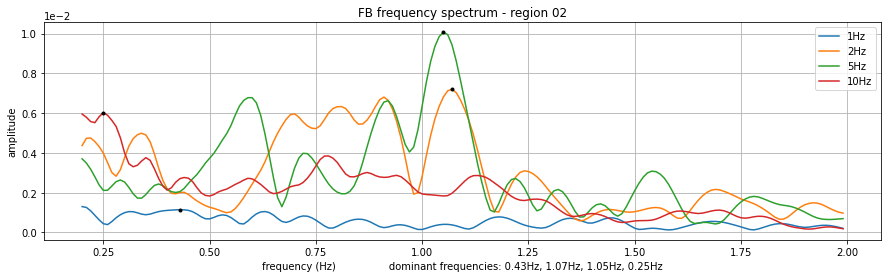

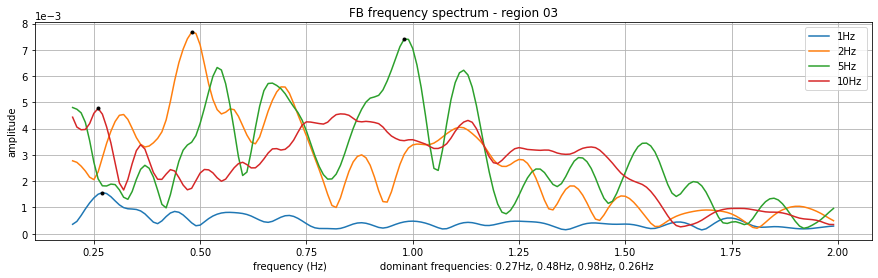

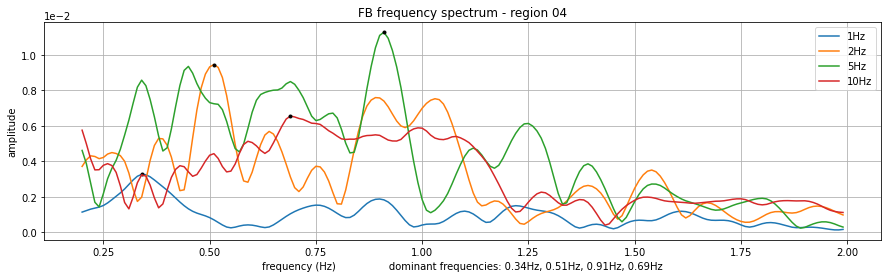

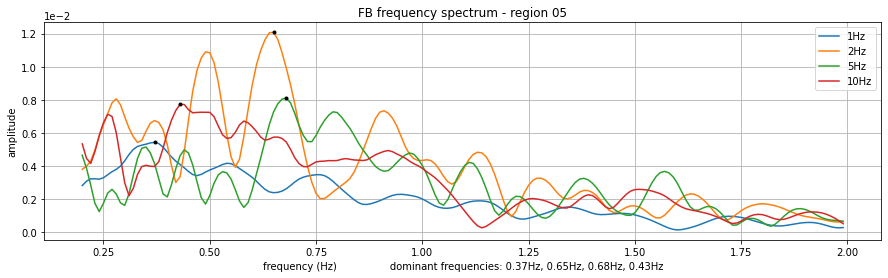

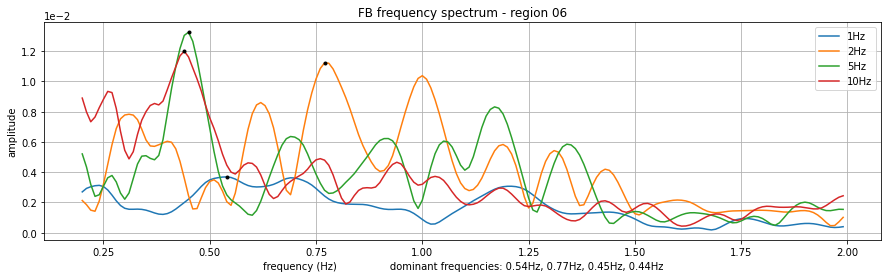

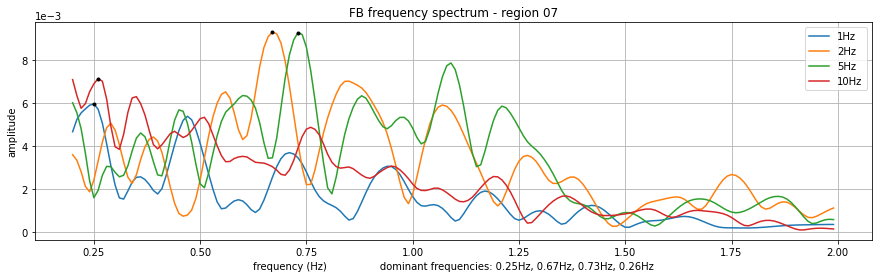

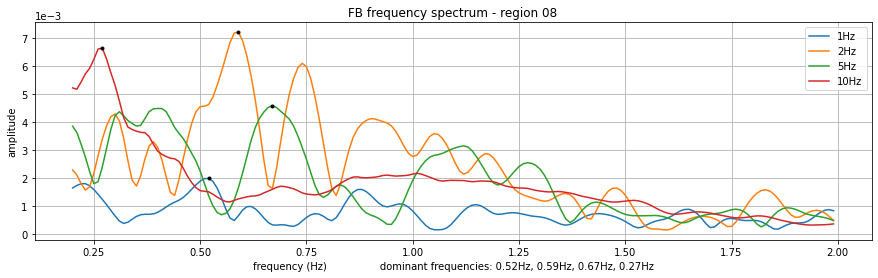

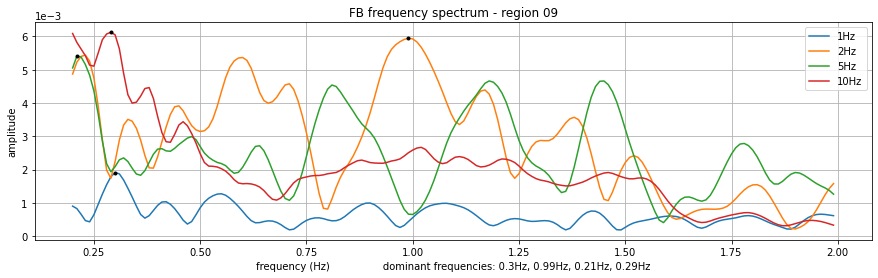

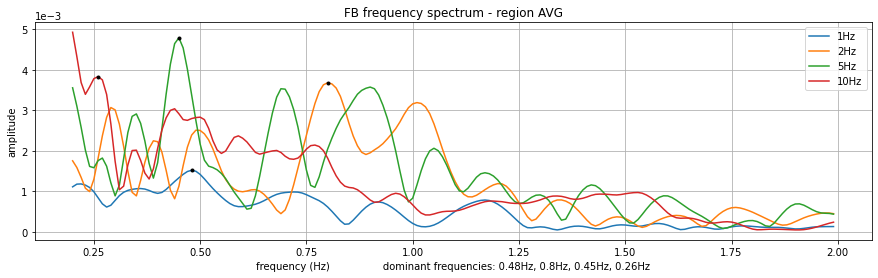

In [3]:
%matplotlib inline

# get the regions and data labels in the selected results directory 
region_files = os.listdir("../results/" + results_widget.value)
region_files = sorted([f for f in region_files if 'apical_region' in f and '.csv' in f])
with open("../results/" + results_widget.value + "/labels.txt") as f:
  data_labels = f.readlines()
data_labels = [x.strip() for x in data_labels] 

n = 11
p = 2**n                   # desired length of resampled data (a power of two for the FFT)
fqall = []                 # the dominant frequencies across all regions
for r in region_files:     # for each region
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [15,4])
  ax.grid(b=True)

  region = r.split('_')[-1].split('-')[0]  # get the region number
  A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + r, delimiter=','))
  A = A0[:,stim_start:stim_done]  # trim the data to the stimulated time
  tmin = np.min(A[0])      # start time
  tmax = np.max(A[0])      # finish time
  trng = tmax-tmin         # time range
  tstp = A0[0,1]-A0[0,0]   # time step
  dmin = np.min(A[1:])     # minimum data value (over all traces)
  dmax = np.max(A[1:])     # maximum data value
  drng = dmax-dmin         # data range
  X0 = A[0]                # the time axis
  Y0 = (A[1:]-dmin) / drng # data axis, normalized to range(0, 1.0)

  sr = p / trng  # the sample rate
  fq = []        # dominant frequency list
  Yall = []      # the spectra
  for idx,y in enumerate(Y0): # for each trace
    f = interp1d(X0, y, kind='cubic')                             # define the resampling function
    X = np.linspace(tmin, tmax, np.int(trng*sr)+1, endpoint=True) # define the new time steps
    Y = f(X)                                                      # resample the original signal

    # apply high-pass filter to eliminate the stimulation "bump" in the data
    sos = signal.butter(5, 0.2, btype='highpass', fs=sr, output='sos')
    Y = signal.sosfiltfilt(sos, Y) # zero phase shift filter

    fmin = 0.2  # minimum frequency to look for
    fmax = 2.0  # maximum
    ########################################################
    if calc_method=='FB':    # the filter bank method
      fX = np.arange(fmin, fmax, 0.01)           # filter bank frequencies (min, max, step)
      fY = []                                    # filter bank responses
      for s in fX:  # for each filter in the bank
        #ofs = 1.0/20  # filter half-width as fraction of octave
        #sos = signal.butter(2, ((2**(-ofs))*s,(2**ofs)*s), btype='bandpass', fs=sr, output='sos')
        sos = signal.butter(1, (s-0.01,s+0.01), btype='bandpass', fs=sr, output='sos')
        Y1 = signal.sosfiltfilt(sos, Y)          # zero phase shift filter
        fY.append(np.sqrt(np.mean(Y1**2)))       # save the rms value of the filtered signal
    ########################################################
    elif calc_method=='FFT': # the FFT method
      N = len(Y)
      T = 1.0 / sr
      Xfft = np.linspace(0.0, 1.0/(2.0*T), N//2)
      Yfft = fft(Y, p)
      s = np.where(Xfft>fmin)[0][0]    # trim results to the specified frequency range
      f = np.where(Xfft>fmax)[0][0]
      fX = Xfft[s:f]
      fY = list(np.abs(Yfft[:N//2])[s:f])        
    ########################################################

    _,pks = signal.find_peaks(fY,height=0)            # find peaks
    didx = fY.index(np.max(pks["peak_heights"]))      # get index of dominant frequency (determined by max amplitude)
    fq.append("{:3.3}Hz".format(fX[didx]))            # append dominant frequency to list

    if results_scale == 'log':
      fY = 10*np.log10(fY)                       # convert spectrum data to dB units
    Yall.append(fY)                              # append spectrum for this trace to list for the region   
    ax.plot(fX,fY,label=str(data_labels[idx]))   # plot the spectrum
    ax.plot(fX[didx],fY[didx],'k.')              # plot the dominant frequencies

  fqall.append(fq) # append the dominant frequencies for this region to the overall list
  ax.legend()
  ax.set_title(calc_method + " frequency spectrum - region " + region)
  if results_scale == "linear":
    ax.set(ylabel="amplitude")
  elif results_scale == "log":
    ax.set(ylabel="amplitude (dB)")
  ax.set(xlabel="frequency (Hz)                 dominant frequencies: " + ', '.join(fq))
  ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

  # save figure to pdf
  fig.savefig("../results/" + results_widget.value +'/' + calc_method + "-spectrum" + "_region_" + region + ".pdf")
  plt.show()
  plt.close() # frees up memory

  # save spectrum to CSV file
  with open ("../results/" + results_widget.value +'/' + calc_method + "-spectrum" + "_region_" + region + ".csv", 'w') as file:
    writer = csv.writer(file)
    results = np.transpose(np.concatenate((np.array([fX]), np.array(Yall))))
    for row in results:
      writer.writerow('{:3.3e}'.format(x) for x in row)

# save dominant frequencies to CSV file
with open ("../results/" + results_widget.value +'/' + calc_method + "-dominant-frequencies_region_ALL.csv", 'w') as file:
  writer = csv.writer(file)
  for row in fqall:
    writer.writerow(x[:-2] for x in row)

